In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork

from args import *
from utils import *

No module named 'phonopy'
No module named 'phonopy'


In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

In [3]:
type(train_dataset[0].x)

torch.Tensor

In [4]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
model = GCNNetwork(in_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-8)

25092 8364 8363


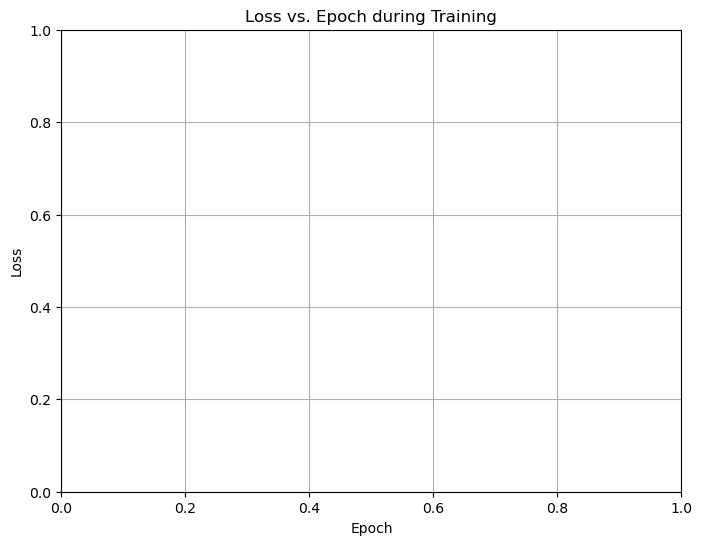

In [5]:
epochs = args["epochs"]

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Epoch 1, training loss(MAE)=0.0248, validating loss(MAE)=0.0259, testing loss(MAE)=0.0258, lr=0.0025


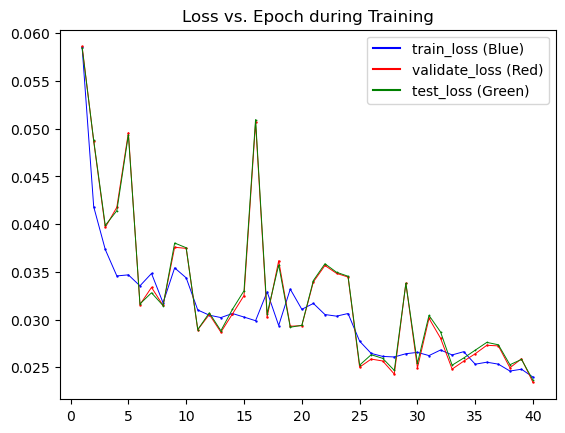

Epoch 2, training loss(MAE)=0.024, validating loss(MAE)=0.0234, testing loss(MAE)=0.0236, lr=0.0025
Epoch 3, training loss(MAE)=0.0233, validating loss(MAE)=0.025, testing loss(MAE)=0.0251, lr=0.0025


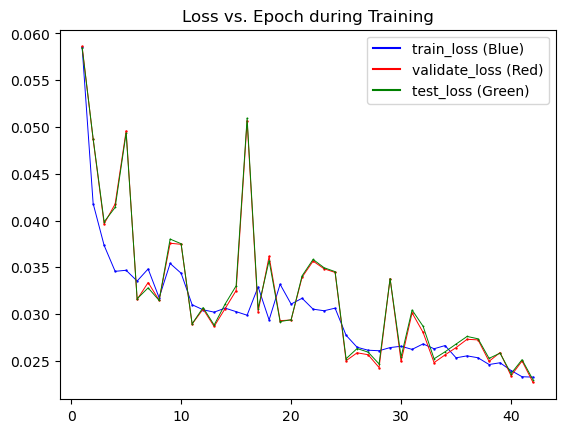

Epoch 4, training loss(MAE)=0.0233, validating loss(MAE)=0.0227, testing loss(MAE)=0.023, lr=0.0025


KeyboardInterrupt: 

In [8]:
epochs = 1000

for epoch in range(1, epochs + 1):

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    progress_msg = "Epoch " + str(epoch)
    progress_msg += ", training loss(MAE)=" + str(round(train_loss, 4))
    progress_msg += ", validating loss(MAE)=" + str(round(val_loss, 4))
    progress_msg += ", testing loss(MAE)=" + str(round(test_loss, 4))
    progress_msg += ", lr=" + str(round(current_lr, 8))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=2)
    print(progress_msg)

MAE loss of formation energy is:  0.2273966372013092


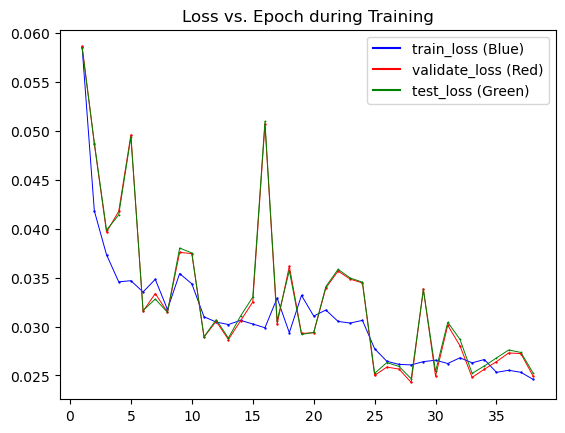

MAE=  2.2186401314290918


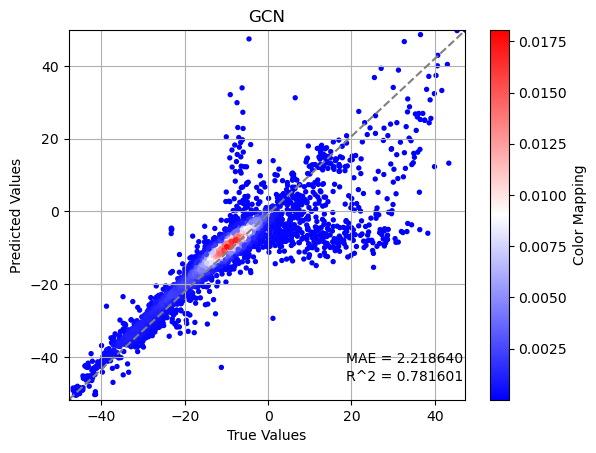

In [7]:
result_path = createResultFolder()
save_hyper_parameter(args, result_path)
save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

# Reverse normalization of test_out and y
min, max = get_data_scale(args)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print("MAE loss of formation energy is: ", loss.item())

# save results
plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path)
save_regression_result(test_out, test_y, result_path)
plot_regression_result("GCN", result_path, plotfilename="regression_figure.jpeg")